In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import cv2

import torch
import torch.nn as nn


from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

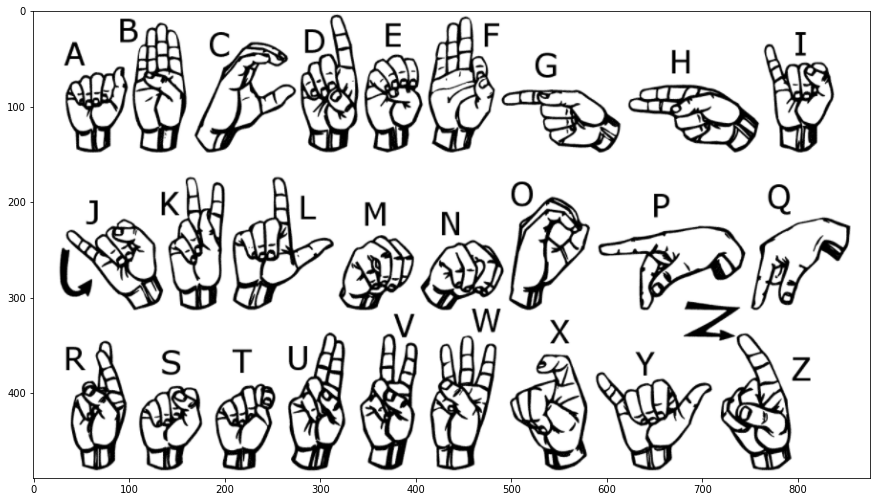

In [3]:

img_path = ["/kaggle/input/sign-language-mnist/american_sign_language.PNG",
            "/kaggle/input/sign-language-mnist/amer_sign3.png",
            "/kaggle/input/sign-language-mnist/amer_sign2.png"]
img = cv2.imread(img_path[0], cv2.IMREAD_COLOR)
plt.figure(figsize=(15,15))
plt.imshow(img)


In [4]:
# Load data
train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


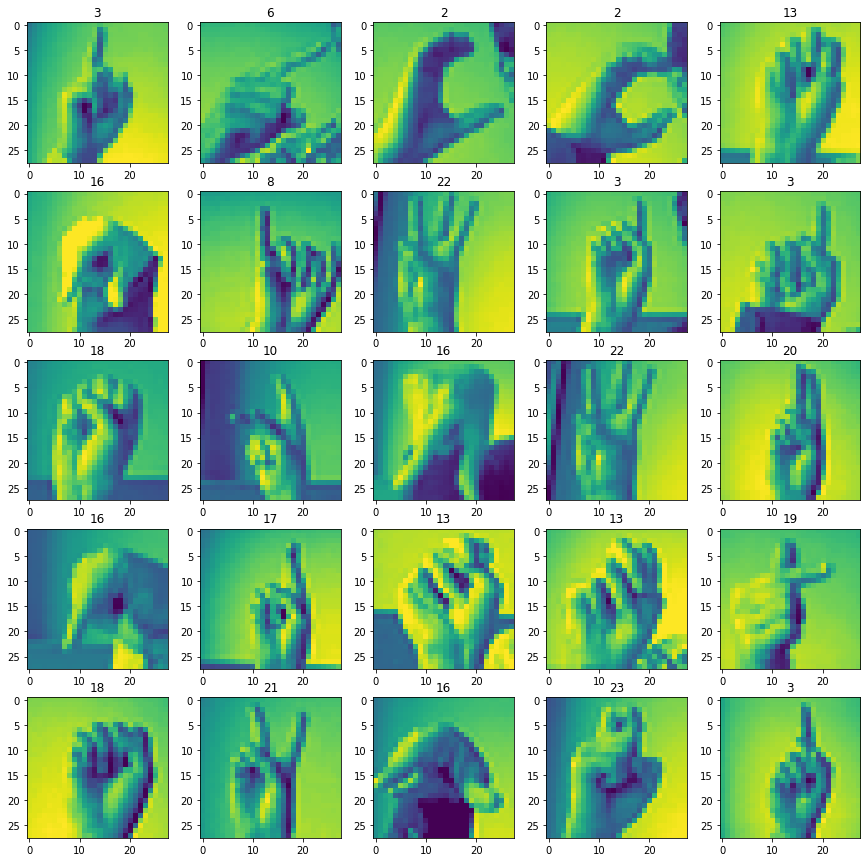

In [5]:
# Examples of images

plt.figure(figsize=(15,15))
for i in range(25):
    img = np.array(train_df.iloc[i, 1:].values).reshape(28,28)

    plt.subplot(5,5, i+1)
    plt.imshow(img)
    plt.title(train_df.iloc[i, 0])

In [6]:
# Small EDA
num_classes = len(train_df.label.unique())
print("Unique labels:", len(train_df.label.unique()))
train_df['label'].value_counts()

Unique labels: 24


17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [7]:
# class for load data

class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, transforms = None):
        
        super().__init__()
        
        self.dataset = dataset
        self.transforms = transforms
        
        
    def __getitem__(self, index):
        
        #Reading image
        item = np.array(self.dataset.iloc[index, 1:].values).reshape(28,28) / 255
        item = torch.from_numpy(item).to(torch.float32)
        item = torch.unsqueeze(item, 0)
        
        label = np.array(self.dataset.iloc[index, 0])
        label = torch.from_numpy(label)
        
        if self.transforms:
            item = self.transforms(item)
            
        return item, label
        
        
    def __len__(self):
        return self.dataset.shape[0]

In [8]:
transform_augmentation = T.Compose([
     T.RandomCrop((28, 28)),
#     transforms.RandomHorizontalFlip(p=0.5),
     T.RandomRotation(degrees=(-20, 20)),
#     transforms.RandomVerticalFlip(p=0.5),
     ])

In [9]:
train_dataset = MNIST_Dataset(train_df, transform_augmentation)
test_dataset = MNIST_Dataset(test_df)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    shuffle=True,
    #sampler = train_random_sampler,
    num_workers = 2,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    shuffle=False,
    #sampler = valid_random_sampler,
    num_workers = 2,
)

In [10]:
sample = next(iter(train_data_loader))
sample[0][0].shape

torch.Size([1, 28, 28])

In [11]:
class ConvSoftmaxClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize layer
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 28x28 -> 14x14
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),  #14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 14x14-> 7x7
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),  # 7x7-> 5x5
            nn.ReLU(),
            
            nn.Flatten(), #  5x5x64 -> 1600
            nn.Linear(5*5*64, 5*5*64),
            nn.ReLU(),
            nn.Linear(5*5*64, 5*5*32),
            nn.ReLU(),

            nn.Linear(5*5*32, num_classes),     
        )
        self.activation = nn.Softmax(dim=1)

    # Required: overrides __call__
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return self.activation(self(x))

    def predict(self, x):
        return torch.argmax(self.activation(self(x)), dim=1)

classifier = ConvSoftmaxClassifier(num_classes+1)

#classifier.to(device)

In [12]:
loss = nn.CrossEntropyLoss()

# Gradient descent update rule
optimizer = torch.optim.SGD(classifier.parameters(), # Put parameters to optimize here 
                            lr=1e-2, # Learning rate
                            weight_decay=1e-5 # Put L2 regularization here
            )

In [13]:
n_epochs = 12

train_history = []
valid_history = []

for i in range(n_epochs):
    # Iterate over batches

    classifier.train()
    epoch_loss = 0
    iter_loss = 0
    for j, (x, y) in enumerate(train_data_loader):
        # Forward
        #x = x.to(device)
        #y = y.to(device)
        y_hat = classifier(x)

        # Compute loss
        loss_batch = loss(y_hat, y)
        
        epoch_loss += loss_batch.item()
        
        iter_loss += loss_batch.item()
        
        if (j > 0) and (j % 300 == 0):
            print("Iter # {}, loss = {:3}".format(j, iter_loss))
            iter_loss = 0
        
        #pbar.set_postfix({'loss_batch': float(loss_batch.item())})

        optimizer.zero_grad() # Do not forget this!
        # Backward: propagate gradients
        loss_batch.backward()
        
        # Update
        optimizer.step()
    
    # Validation    
    with torch.no_grad():
        classifier.eval() # Equivalent: classifier.eval()

        valid_loss = 0
        for x, y in test_data_loader:
            y_hat = classifier(x)
            loss_batch = loss(y_hat, y)            
            valid_loss += loss_batch.item()
    
    train_history.append(epoch_loss)
    valid_history.append(valid_loss)
    
    print("Epoch # {}, Train loss = {:3}, Valid loss = {:3}".format(i+1, epoch_loss, valid_loss))

Iter # 300, loss = 968.1314516067505
Iter # 600, loss = 962.4721970558167
Iter # 900, loss = 959.8750216960907
Iter # 1200, loss = 956.0066750049591
Iter # 1500, loss = 954.4222226142883
Epoch # 1, Train loss = 5483.774684429169, Valid loss = 1440.5090091228485
Iter # 300, loss = 955.4504508972168
Iter # 600, loss = 951.0826280117035
Iter # 900, loss = 948.208242893219
Iter # 1200, loss = 939.9886543750763
Iter # 1500, loss = 900.8791840076447
Epoch # 2, Train loss = 5284.054158449173, Valid loss = 1128.984207868576
Iter # 300, loss = 700.3383909463882
Iter # 600, loss = 579.0418556928635
Iter # 900, loss = 501.1789367198944
Iter # 1200, loss = 431.7094749212265
Iter # 1500, loss = 352.690580368042
Epoch # 3, Train loss = 2788.1676968336105, Valid loss = 510.6188205778599
Iter # 300, loss = 269.92953938245773
Iter # 600, loss = 232.25947949290276
Iter # 900, loss = 192.16975004971027
Iter # 1200, loss = 164.93598571419716
Iter # 1500, loss = 126.90714928507805
Epoch # 4, Train loss = 1

Text(0.5, 1.0, 'Valid Loss')

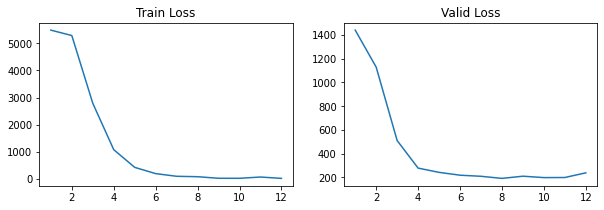

In [14]:
#Train history

idx = [i for i in range(1,len(train_history)+1)]

plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(idx, train_history)
plt.title("Train Loss")


plt.subplot(1, 2, 2)
plt.plot(idx, valid_history)
plt.title("Valid Loss")

In [15]:
with torch.no_grad():
    #classifier.cuda()
    classifier.eval() # Equivalent: classifier.eval()

    test_preds = []
    test_labels = []
    for x, y in test_data_loader:
        #x = x.cuda()
        #y = y.cuda()
        test_labels += list(y)#.cpu())
        #pred = classifier.predict(x)
        
        test_preds += list(classifier.predict(x))#.cpu())

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       331
           1       1.00      0.90      0.95       432
           2       0.90      1.00      0.95       310
           3       0.74      0.98      0.84       245
           4       0.99      0.92      0.95       498
           5       0.87      1.00      0.93       247
           6       1.00      0.87      0.93       348
           7       1.00      0.97      0.99       436
           8       0.75      0.95      0.84       288
          10       0.82      0.94      0.87       331
          11       1.00      0.94      0.97       209
          12       0.87      0.84      0.86       394
          13       0.80      0.83      0.81       291
          14       0.99      0.83      0.90       246
          15       0.99      0.96      0.97       347
          16       0.69      1.00      0.81       164
          17       0.66      0.56      0.61       144
          18       0.70    

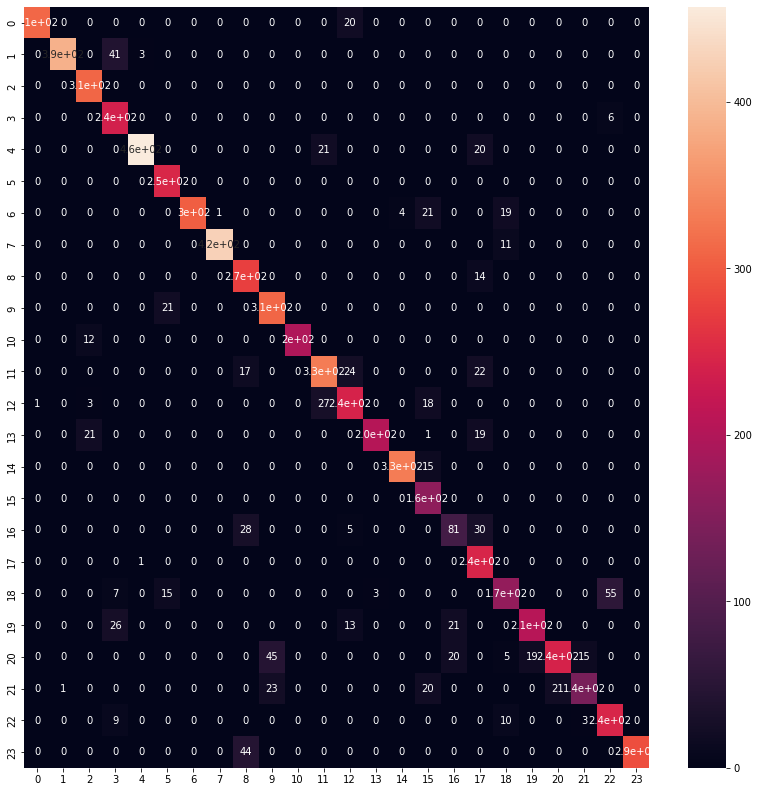

In [16]:
# Confusion matrix

plt.figure(figsize=(14,14))
cm = confusion_matrix(test_labels, test_preds)#, labels=clf.classes_)
sns.heatmap(cm, annot=True)
plt.show()

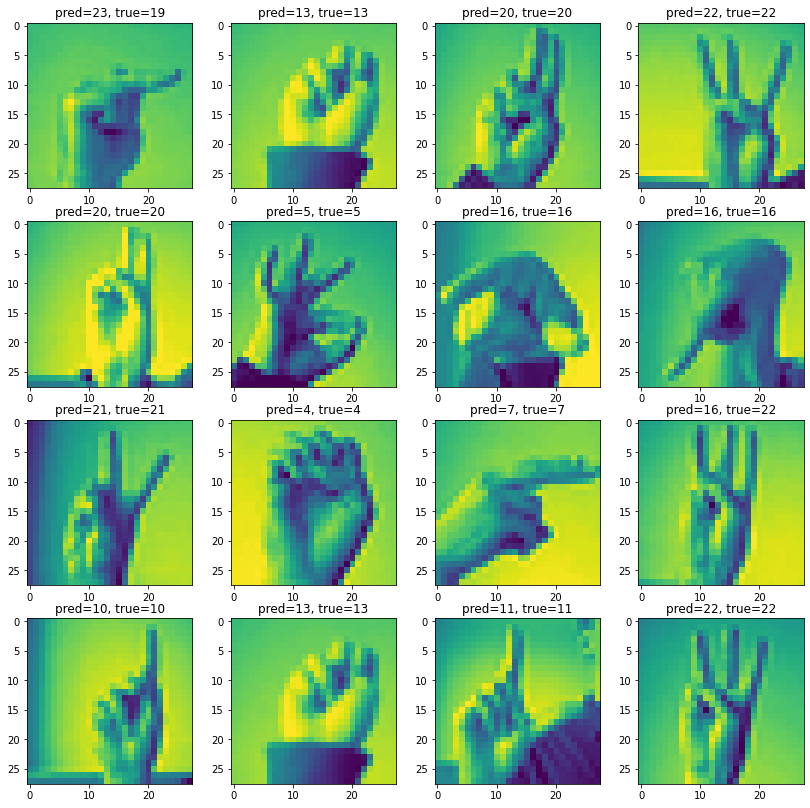

In [17]:
# Examples of predictions with images
skip = 3
for x, y in test_data_loader:
    if (skip > 0):
        skip -= 1
        continue
    preds = list(classifier.predict(x))
    break

plt.figure(figsize=(14,14))
for i in range(16):
    img = np.array(train_df.iloc[i, 1:].values).reshape(28,28)

    plt.subplot(4,4, i+1)
    plt.imshow(x[i].squeeze().detach().numpy())
    plt.title("pred={}, true={}".format(preds[i],y[i]))

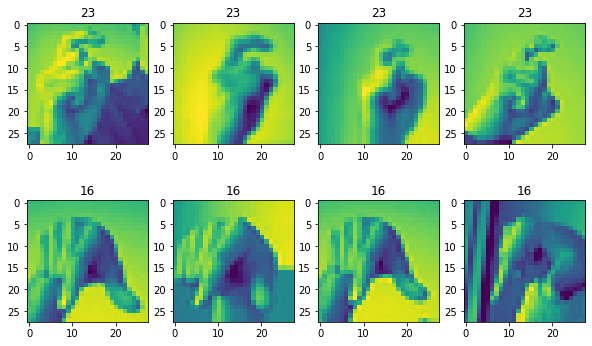

In [18]:
# Examples of the most confused labels  (11, 4)

a = train_df[train_df["label"] == 23].sample(4)
b = train_df[train_df["label"] == 16].sample(4)

plt.figure(figsize=(10,6))
for i in range(4):
    img = np.array(a.iloc[i, 1:].values).reshape(28,28)
    plt.subplot(2,4, i+1)
    plt.imshow(img)
    plt.title(a.iloc[i, 0])

for i in range(4):
    img = np.array(b.iloc[i, 1:].values).reshape(28,28)
    plt.subplot(2,4, i+1+4)
    plt.imshow(img)
    plt.title(b.iloc[i, 0])